1. Install docker neo4j - https://neo4j.com/docs/operations-manual/current/docker/introduction/
2. Start docker container
docker run \
    --restart always \
    --publish=7474:7474 --publish=7687:7687 \
    --env NEO4J_AUTH=neo4j/your_password \
    --volume=/path/to/your/data:/data \
    neo4j
3. Install neo4j Python driver


In [1]:
%pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.6/296.6 kB 6.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from neo4j import GraphDatabase

# Define the URI, username, and password
uri = "bolt://localhost:7687"  # This is the default URI for local Neo4j
username = "neo4j"             # Replace with your username
password = "bans2008"     # Replace with your password

# Initialize the driver
driver = GraphDatabase.driver(uri, auth=(username, password))

# Define a function to execute Cypher queries
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]

# Example query to return all nodes in the database
query = "MATCH (n) RETURN n LIMIT 5"
result = run_query(query)

# Display the results
for record in result:
    print(record)


<Record n=<Node element_id='4:31cb65de-b85b-4836-ba6d-57e56548629e:0' labels=frozenset({'Person'}) properties={'name': 'Alice', 'age': 25}>>


Create node to test

In [4]:
query = "CREATE (p:Person {name: 'Alice', age: 25})"
run_query(query)


[]

In [2]:
query = "MATCH (p:Person) RETURN p.name AS name, p.age AS age"
result = run_query(query)

for record in result:
    print(f"Name: {record['name']}, Age: {record['age']}")


Name: Alice, Age: 25


Adverse Event Prediction
Build knowledge graph by extracting relevant features
1. Admissions Data
2. ICU Data
3. Patients Data
4. Diagnosis Data
5. Chart Events Data
6. Procedure Data
7. Lab Data

Step 1. Load data into pandas dataframes
a. Define the path of the csv files

In [4]:
dataset_labevents = 'mimic/LABEVENTS.csv'
dataset_chartevents = 'mimic/CHARTEVENTS.csv'
dataset_labitems = 'mimic/D_LABITEMS.csv'
dataset_patients = 'mimic/PATIENTS.csv'
dataset_admissions = 'mimic/ADMISSIONS.csv'
dataset_diagnoses = 'mimic/DIAGNOSES_ICD.csv'
dataset_icd9_code = 'mimic/D_ICD_DIAGNOSES.csv'

In [12]:
# load to csv
import pandas as pd
patients_df = pd.read_csv(dataset_patients)
admissions_df = pd.read_csv(dataset_admissions)
# change column names to lowercase
patients_df.columns = patients_df.columns.str.lower()
admissions_df.columns = admissions_df.columns.str.lower()
# combine patients and admissions
patients_df['dob'] = pd.to_datetime(patients_df['dob'])
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])

# Align 'dob' with 'subject_id' in admissions_df
merged_df = admissions_df.merge(patients_df[['subject_id', 'dob']], on='subject_id', how='left')

# Remove rows where 'dob' is after 'admittime' or where either date is missing
merged_df = merged_df[(merged_df['admittime'] > merged_df['dob']) & merged_df['dob'].notna() & merged_df['admittime'].notna()]

# Calculate age in years
#merged_df['age'] = (merged_df['admittime'] - merged_df['dob']).astype('timedelta64[Y]')


# Drop columns not needed for prediction
merged_df = admissions_df[['subject_id', 'hadm_id', 'admission_type', 'ethnicity']].copy()
merged_df['gender'] = patients_df['gender'].map({'M': 0, 'F': 1})

# One-hot encode ethnicity
merged_df = pd.get_dummies(merged_df, columns=['ethnicity'])
merged_df.head()

,subject_id,hadm_id,admission_type,gender,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_ASIAN - ASIAN INDIAN,ethnicity_ASIAN - CAMBODIAN,ethnicity_ASIAN - CHINESE,...,ethnicity_PATIENT DECLINED TO ANSWER,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN
0,22,165315,EMERGENCY,1.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,23,152223,ELECTIVE,1.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,23,124321,EMERGENCY,0.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,24,161859,EMERGENCY,0.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,25,129635,EMERGENCY,1.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


Identify and Process Sepsis Diagnoses
Filter the diagnoses_df for sepsis-related ICD-9 codes '99591', '99592', '78552'.

In [13]:
df_icd9_code = pd.read_csv(dataset_icd9_code)

df_icd9_code.columns = df_icd9_code.columns.str.lower()
result = df_icd9_code.loc[df_icd9_code['icd9_code'].isin(['99591', '99592', '78552'])]
print(result)

       row_id icd9_code    short_title     long_title
10304   11403     99591         Sepsis         Sepsis
10305   11404     99592  Severe sepsis  Severe sepsis
13142   12991     78552   Septic shock   Septic shock


In [19]:
# get the diagnoses and filter by sepsis icd9 codes
diagnoses_icd = pd.read_csv(dataset_diagnoses, usecols=['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE'])

sepsis_icd9_codes = ['99591', '99592', '78552']
sepsis_diagnoses = diagnoses_icd.loc[diagnoses_icd['ICD9_CODE'].isin(sepsis_icd9_codes)]
sepsis_diagnoses.columns = sepsis_diagnoses.columns.str.lower()
sepsis_diagnoses.head()

,subject_id,hadm_id,icd9_code
87,117,164853,99592
144,124,138376,99592
276,64,172056,99591
450,85,112077,99591
738,21,111970,78552


In [21]:
# combine to patients and admissions and filter patients with sepsis diagnoses 
# and label as sepsis_patients 1 and 0 otherwise
sepsis_patients = merged_df.merge(sepsis_diagnoses, on=['subject_id', 'hadm_id'], how='left')
sepsis_patients['sepsis'] = sepsis_patients['icd9_code'].notna().astype(int)
sepsis_patients.drop(columns=['icd9_code'], inplace=True)
sepsis_patients.head()





,subject_id,hadm_id,admission_type,gender,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_ASIAN - ASIAN INDIAN,ethnicity_ASIAN - CAMBODIAN,ethnicity_ASIAN - CHINESE,...,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN,sepsis
0,22,165315,EMERGENCY,1.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0
1,23,152223,ELECTIVE,1.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0
2,23,124321,EMERGENCY,0.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0
3,24,161859,EMERGENCY,0.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0
4,25,129635,EMERGENCY,1.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0


In [22]:
# count number sepsis patients
sepsis_patients['sepsis'].sum()

7770

In [23]:
# total number of patients
sepsis_patients['sepsis'].count()

61421

In [30]:
# save to csv
sepsis_patients.to_csv('sepsis_patients.csv', index=False)

Extract and Aggregate Lab Results
WBC, HCO3, PLATELET, PH, GLUCOSE, BUN, CREATININE

In [26]:
lab_results_itemids = [51300, 50885, 51006, 50813, 50912, 51265, 51146] # WBC, HCO3, PLATELET, PH, GLUCOSE, BUN, CREATININE
labevents = pd.read_csv(dataset_labevents, usecols=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM'])
labevents = labevents[labevents['ITEMID'].isin(lab_results_itemids)]
labevents.columns = labevents.columns.str.lower()
print(labevents.count())
# drop na values
labevents.dropna(inplace=True)
print(labevents.count())
labevents.head()


subject_id    2967466
hadm_id       2297841
itemid        2967466
charttime     2967466
valuenum      2966910
dtype: int64
subject_id    2297442
hadm_id       2297442
itemid        2297442
charttime     2297442
valuenum      2297442
dtype: int64


,subject_id,hadm_id,itemid,charttime,valuenum
166,3,145834.0,50912,2101-10-20 16:40:00,3.2
177,3,145834.0,50885,2101-10-22 04:00:00,0.8
180,3,145834.0,50912,2101-10-22 04:00:00,1.9
187,3,145834.0,51006,2101-10-22 04:00:00,36.0
189,3,145834.0,51146,2101-10-22 04:00:00,0.3


In [27]:
# convert hadm_id to int
labevents['hadm_id'] = labevents['hadm_id'].astype(int)

In [28]:
labevents.head()

,subject_id,hadm_id,itemid,charttime,valuenum
166,3,145834,50912,2101-10-20 16:40:00,3.2
177,3,145834,50885,2101-10-22 04:00:00,0.8
180,3,145834,50912,2101-10-22 04:00:00,1.9
187,3,145834,51006,2101-10-22 04:00:00,36.0
189,3,145834,51146,2101-10-22 04:00:00,0.3


In [29]:
# save to csv
labevents.to_csv('labevents.csv', index=False)

In [31]:
# load from csv
lab_events_df = pd.read_csv('labevents.csv')
# aggregate lab results by hadm_id
lab_features = lab_events_df.groupby(['subject_id', 'hadm_id', 'itemid']).agg(
    mean_value=('valuenum', 'mean'),
    max_value=('valuenum', 'max')
).reset_index()
# Pivot to get individual lab items as columns
lab_features = lab_features.pivot(index=['subject_id', 'hadm_id'], columns='itemid', values=['mean_value', 'max_value']).fillna(0)
lab_features.columns = [f"{stat}_{item}" for stat, item in lab_features.columns]  # Flatten MultiIndex
lab_features = lab_features.reset_index()
lab_features.head()

,subject_id,hadm_id,mean_value_50813,mean_value_50885,mean_value_50912,mean_value_51006,mean_value_51146,mean_value_51265,mean_value_51300,max_value_50813,max_value_50885,max_value_50912,max_value_51006,max_value_51146,max_value_51265,max_value_51300
0,2,163353,0.000000,9.300,0.000000,0.000000,0.000000,153.500000,0.0,0.0,9.3,0.0,0.0,0.0,302.0,0.0
1,3,145834,3.545455,0.800,1.826667,28.133333,0.100000,210.866667,0.0,8.8,0.8,3.2,53.0,0.3,359.0,0.0
2,4,185777,2.100000,2.050,0.450000,16.125000,0.133333,286.428571,0.0,2.1,2.2,0.5,20.0,0.2,388.0,0.0
3,5,178980,0.000000,0.000,0.000000,0.000000,0.000000,309.000000,0.0,0.0,0.0,0.0,0.0,0.0,309.0,0.0
4,6,107064,2.640000,0.225,3.741176,53.941176,0.100000,247.947368,0.0,3.9,0.3,11.7,91.0,0.1,331.0,0.0


Get vital signs from chart events

In [32]:
# Define the relevant itemids for vital signs and FiO2
vital_signs_itemids = [220050, 220052, 220210, 220277, 220045, 223761]  # SBP, MAP, RR, PulOx, HR, Temp
fio2_itemid = [223835]  # FiO2
relevant_itemids = vital_signs_itemids + fio2_itemid


ChartEvents table is huge, loading it will cause vscode to crash

1. Load by chunks
2. Load only admission id in patients, admissions df

In [34]:
# unique admission ids
unique_admission_ids = sepsis_patients['hadm_id'].unique()
# convert to set
unique_admission_ids = set(unique_admission_ids)
print(len(unique_admission_ids))

58976


In [35]:
# Initialize an empty list to store filtered data
filtered_chartevents = []

# Define the chunk size (number of rows to read at a time)
chunk_size = 100000  # 100k rows per chunk

# Read CHARTEVENTS in chunks
chartevents_chunks = pd.read_csv(dataset_chartevents, usecols=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM'], chunksize=chunk_size)

# Process each chunk
for chunk in chartevents_chunks:
    # Filter the chunk based on relevant itemid and sepsis patients' hadm_id
    filtered_chunk = chunk[(chunk['ITEMID'].isin(relevant_itemids)) & (chunk['HADM_ID'].isin(unique_admission_ids))]
    
    # Append the filtered data to the list
    filtered_chartevents.append(filtered_chunk)

# Concatenate all the filtered chunks into a single DataFrame
filtered_chartevents_df = pd.concat(filtered_chartevents, ignore_index=True)

In [36]:
# write to csv
filtered_chartevents_df.to_csv('filtered_chartevents_gnn.csv', index=False)

In [38]:
# convert columns to lower case
filtered_chartevents_df.columns = filtered_chartevents_df.columns.str.lower()
# aggregate chart events by hadm_id, subejct_id and itemid
# Aggregate vitals by patient and admission, calculating mean, min, and max
vital_features = filtered_chartevents_df.groupby(['subject_id', 'hadm_id', 'itemid']).agg(
    mean_value=('valuenum', 'mean'),
    max_value=('valuenum', 'max'),
    min_value=('valuenum', 'min')
).reset_index()

# Pivot for each vital sign
vital_features = vital_features.pivot(index=['subject_id', 'hadm_id'], columns='itemid', values=['mean_value', 'max_value', 'min_value']).fillna(0)
vital_features.columns = [f"{stat}_{item}" for stat, item in vital_features.columns]  # Flatten MultiIndex
vital_features = vital_features.reset_index()
vital_features.head()

,subject_id,hadm_id,mean_value_220045,mean_value_220050,mean_value_220052,mean_value_220210,mean_value_220277,mean_value_223761,mean_value_223835,max_value_220045,...,max_value_220277,max_value_223761,max_value_223835,min_value_220045,min_value_220050,min_value_220052,min_value_220210,min_value_220277,min_value_223761,min_value_223835
0,23,124321,76.694444,129.294118,88.545455,17.114286,98.114286,97.342857,0.000000,115.0,...,100.0,98.6,0.0,59.0,65.0,49.0,11.0,95.0,95.8,0.0
1,34,144319,55.864865,0.000000,0.000000,17.270270,95.878788,97.375000,60.000000,72.0,...,100.0,98.7,60.0,43.0,0.0,0.0,9.0,75.0,96.4,60.0
2,36,165660,85.586538,0.000000,211.500000,18.798077,93.250000,99.076000,57.586207,105.0,...,98.0,100.7,100.0,67.0,0.0,-11.0,10.0,83.0,96.3,40.0
3,85,112077,106.276596,0.000000,0.000000,28.340426,97.170213,98.881818,0.000000,136.0,...,100.0,100.4,0.0,79.0,0.0,0.0,20.0,90.0,98.2,0.0
4,107,174162,78.500000,0.000000,0.000000,15.017857,97.214286,98.425000,75.000000,95.0,...,100.0,99.3,100.0,60.0,0.0,0.0,5.0,84.0,97.8,50.0


In [41]:
# combine lab and vital features with patients and admissions
combined_df = sepsis_patients.merge(lab_features, on=['subject_id', 'hadm_id'], how='left')
combined_df = combined_df.merge(vital_features, on=['subject_id', 'hadm_id'], how='left')


combined_df.head()

,subject_id,hadm_id,admission_type,gender,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_ASIAN - ASIAN INDIAN,ethnicity_ASIAN - CAMBODIAN,ethnicity_ASIAN - CHINESE,...,max_value_220277,max_value_223761,max_value_223835,min_value_220045,min_value_220050,min_value_220052,min_value_220210,min_value_220277,min_value_223761,min_value_223835
0,22,165315,EMERGENCY,1.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23,152223,ELECTIVE,1.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,124321,EMERGENCY,0.0,False,False,False,False,False,False,...,100.0,98.6,0.0,59.0,65.0,49.0,11.0,95.0,95.8,0.0
3,24,161859,EMERGENCY,0.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25,129635,EMERGENCY,1.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
combined_df.columns

Index(['subject_id', 'hadm_id', 'admission_type', 'gender',
       'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
       'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'ethnicity_ASIAN', 'ethnicity_ASIAN - ASIAN INDIAN',
       'ethnicity_ASIAN - CAMBODIAN', 'ethnicity_ASIAN - CHINESE',
       'ethnicity_ASIAN - FILIPINO', 'ethnicity_ASIAN - JAPANESE',
       'ethnicity_ASIAN - KOREAN', 'ethnicity_ASIAN - OTHER',
       'ethnicity_ASIAN - THAI', 'ethnicity_ASIAN - VIETNAMESE',
       'ethnicity_BLACK/AFRICAN', 'ethnicity_BLACK/AFRICAN AMERICAN',
       'ethnicity_BLACK/CAPE VERDEAN', 'ethnicity_BLACK/HAITIAN',
       'ethnicity_CARIBBEAN ISLAND', 'ethnicity_HISPANIC OR LATINO',
       'ethnicity_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'ethnicity_HISPANIC/LATINO - COLOMBIAN',
       'ethnicity_HISPANIC/LATINO - CUBAN',
       'ethnicity_HISPANIC/LATINO - DOMINICAN',
       'ethnicity_HISPANIC/LATINO - GUATEMALAN',
       'ethnicity_HISPANIC/LATINO -

In [43]:
# save to csv
combined_df.to_csv('sepsis_data_gnn.csv', index=False)

In [ ]:
# Define item IDs for filtering
vital_signs_itemids = [220050, 220052, 220210, 220277, 220045, 223761] 
lab_results_itemids = [51300, 50885, 51006, 50813, 50912, 51265, 51146]
# Helper function to create a patient node
def create_patient(tx, patient_data):
    # Collect ethnicity fields where value is 1
    ethnicity_fields = [col for col in patient_data.index if col.startswith("ethnicity_") and patient_data[col] == 1]
    ethnicity = ", ".join([field.replace("ethnicity_", "").replace("_", " ") for field in ethnicity_fields])
    
    # Create patient node with demographic and sepsis information
    tx.run("""
        MERGE (p:Patient {id: $subject_id, hadm_id: $hadm_id})
        SET p.admission_type = $admission_type,
            p.gender = $gender,
            p.ethnicity = $ethnicity,
            p.sepsis = $sepsis
        """, 
        subject_id=patient_data['subject_id'],
        hadm_id=patient_data['hadm_id'],
        admission_type=patient_data['admission_type'],
        gender=patient_data['gender'],
        ethnicity=ethnicity,
        sepsis=patient_data['sepsis']
    )

# Helper function to create lab nodes and relationships
def create_lab_relationships(tx, patient_id, lab_data):
    for col in lab_data.index:
        if col.startswith("mean_value_") or col.startswith("max_value_"):
            item_id = col.split('_')[-1]
            stat_type = col.split('_')[0]  # 'mean' or 'max'
            value = lab_data[col]
            
            # Skip if value is missing or zero
            if value == 0 or pd.isna(value):
                continue

            # Create lab node and relationship
            tx.run("""
                MERGE (l:Lab {id: $lab_id, item_id: $item_id})
                SET l.value = $value, l.stat_type = $stat_type
                MERGE (p:Patient {id: $patient_id})-[:HAS_LAB_RESULT]->(l)
                """, 
                lab_id=f"Lab_{item_id}_{stat_type}",
                item_id=item_id,
                value=value,
                stat_type=stat_type,
                patient_id=patient_id
            )

# Helper function to create vital sign nodes and relationships
def create_vital_relationships(tx, patient_id, vital_data):
    for col in vital_data.index:
        if col.startswith("mean_value_") or col.startswith("max_value_") or col.startswith("min_value_"):
            item_id = col.split('_')[-1]
            stat_type = col.split('_')[0]  # 'mean', 'max', or 'min'
            value = vital_data[col]
            
            # Skip if value is missing or zero
            if value == 0 or pd.isna(value):
                continue

            # Create vital sign node and relationship
            tx.run("""
                MERGE (v:VitalSign {id: $vital_id, item_id: $item_id})
                SET v.value = $value, v.stat_type = $stat_type
                MERGE (p:Patient {id: $patient_id})-[:HAS_VITAL_SIGN]->(v)
                """, 
                vital_id=f"Vital_{item_id}_{stat_type}",
                item_id=item_id,
                value=value,
                stat_type=stat_type,
                patient_id=patient_id
            )

# Main function to load the dataframe into Neo4j
def load_data_to_neo4j(df):
    with driver.session() as session:
        for _, row in df.iterrows():
            # Extract data for each part
            patient_data = row[['subject_id', 'hadm_id', 'admission_type', 'gender', 'sepsis'] + 
                               [col for col in row.index if col.startswith("ethnicity_")]]
            # check for lab item ids
               # Filter lab_data using lab_results_itemids
            lab_data = row[[col for col in row.index if any(str(item_id) in col for item_id in lab_results_itemids) 
                            and (col.startswith("mean_value_") or col.startswith("max_value_"))]]
            
            # Filter vital_data using vital_signs_itemids
            vital_data = row[[col for col in row.index if any(str(item_id) in col for item_id in vital_signs_itemids) 
                              and (col.startswith("mean_value_") or col.startswith("max_value_") or col.startswith("min_value_"))]]
          
            # Create patient node
            session.write_transaction(create_patient, patient_data)
            
            # Create lab relationships
            session.write_transaction(create_lab_relationships, f"{patient_data['subject_id']}", lab_data)
            
            # Create vital relationships
            session.write_transaction(create_vital_relationships, f"{patient_data['subject_id']}", vital_data)

# Load data to Neo4j
load_data_to_neo4j(combined_df)

# Close the Neo4j connection
#driver.close()

Construct the knowledge graph
1. knowledge graph (KG) with nodes representing patients, diagnoses, lab results, and vital signs
2. Each patient is connected to relevant diagnoses, lab results, and vital signs as edges

Get data Neo4j database 
1. Query
2. Process gender data
3. Aggregate lab and vital signs data
4. Prepare final feature matrix
5. Split data for training and testing


In [59]:
query = """
MATCH (p:Patient)
OPTIONAL MATCH (p)-[:HAS_LAB_RESULT]->(l:Lab)
OPTIONAL MATCH (p)-[:HAS_VITAL_SIGN]->(v:VitalSign)
RETURN 
    p.id AS patient_id, 
    p.age AS age, 
    p.gender AS gender, 
    p.sepsis AS label, 
    collect(DISTINCT l.value) AS lab_values, 
    collect(DISTINCT v.value) AS vital_signs
"""

# Function to execute the query and load data into a pandas DataFrame
def get_data_from_neo4j(driver, query):
    with driver.session() as session:
        result = session.run(query)
        data = []
        for record in result:
            data.append({
                'patient_id': record['patient_id'],
                'age': record['age'],
                'gender': record['gender'],
                'label': record['label'],
                'lab_values': record['lab_values'],
                'vital_signs': record['vital_signs']
            })
    return pd.DataFrame(data)

# Load the data into a DataFrame
data_df = get_data_from_neo4j(driver, query)
data_df.head()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\nMATCH (p:Patient)\nOPTIONAL MATCH (p)-[:HAS_LAB_RESULT]->(l:Lab)\nOPTIONAL MATCH (p)-[:HAS_VITAL_SIGN]->(v:VitalSign)\nRETURN \n    p.id AS patient_id, \n    p.age AS age, \n    p.gender AS gender, \n    p.sepsis AS label, \n    collect(DISTINCT l.value) AS lab_values, \n    collect(DISTINCT v.value) AS vital_signs\n'


,patient_id,age,gender,label,lab_values,vital_signs
0,22,None,1.0,0.0,[],[]
1,22,None,NaN,NaN,"[1.3142857142857143, 0.6499999999999999, 8.0, ...",[]
2,23,None,1.0,0.0,[],[]
3,23,None,NaN,NaN,"[0.6499999999999999, 8.0, 199.0, 0.7, 9.0, 234...","[95.03030303030303, 146.6875, 107.6875, 17.212..."
4,23,None,0.0,0.0,[],[]


In [60]:
# Process demographic data
# drop the age
data_df.drop(columns=['age'], inplace=True)
data_df.head()


,patient_id,gender,label,lab_values,vital_signs
0,22,1.0,0.0,[],[]
1,22,NaN,NaN,"[1.3142857142857143, 0.6499999999999999, 8.0, ...",[]
2,23,1.0,0.0,[],[]
3,23,NaN,NaN,"[0.6499999999999999, 8.0, 199.0, 0.7, 9.0, 234...","[95.03030303030303, 146.6875, 107.6875, 17.212..."
4,23,0.0,0.0,[],[]


In [61]:
aggregations = {
    'gender': 'first',  # Use the first non-null gender value
    'label': 'first',  # Use the first non-null label value
    'lab_values': lambda x: list(set(sum(x, []))),  # Combine lists and remove duplicates
    'vital_signs': lambda x: list(set(sum(x, [])))  # Combine lists and remove duplicates
}
consolidated_df = data_df.groupby('patient_id').agg(aggregations).reset_index()
consolidated_df.head()

,patient_id,gender,label,lab_values,vital_signs
0,2,0.0,0.0,[],[]
1,3,0.0,0.0,[],[]
2,4,0.0,0.0,[],[]
3,5,0.0,0.0,[],[]
4,6,0.0,0.0,[],[]


In [62]:
# find gender with value 1.0 and 0.0

consolidated_df['gender'].value_counts()

gender
0.0    20344
1.0    15998
Name: count, dtype: int64

In [64]:
import numpy as np

# Aggregate lab values
consolidated_df['lab_mean'] = consolidated_df['lab_values'].apply(lambda x: np.mean(x) if x else 0)
consolidated_df['lab_max'] = consolidated_df['lab_values'].apply(lambda x: np.max(x) if x else 0)

# Aggregate vital sign values
consolidated_df['vital_mean'] = consolidated_df['vital_signs'].apply(lambda x: np.mean(x) if x else 0)
consolidated_df['vital_max'] = consolidated_df['vital_signs'].apply(lambda x: np.max(x) if x else 0)

# Drop original list columns now that we have summary features
consolidated_df = consolidated_df.drop(columns=['lab_values', 'vital_signs'])

# Display processed lab and vital sign features
consolidated_df[['lab_mean', 'lab_max', 'vital_mean', 'vital_max']].head()


,lab_mean,lab_max,vital_mean,vital_max
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [67]:
# save consolidated data to csv
consolidated_df.to_csv('consolidated_data_gcn.csv', index=False)

In [1]:
# load consolidated data from csv
import pandas as pd
consolidated_df = pd.read_csv('consolidated_data_gcn.csv')

In [2]:
# Select relevant features and labels
# fix NaN values in features
consolidated_df.fillna(0, inplace=True)
features = consolidated_df[[ 'gender', 'lab_mean', 'lab_max', 'vital_mean', 'vital_max']].values
labels = consolidated_df['label'].fillna(0).astype(int).values  # Fill missing labels if necessary

# Display feature and label shapes
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (92718, 5)
Labels shape: (92718,)


In [3]:
from sklearn.model_selection import train_test_split

# Split features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (74174, 5)
Testing set shape: (18544, 5)


1. Load node and Edge data into DGL
2. Define the GNN Model architecture
3. Initialize the Model, Loss and Optimizer
4. Train the Model
5. Evaluate the Model


In [4]:
import dgl
import torch
import numpy as np

num_nodes = X_train.shape[0]  # Number of nodes in the graph
# Initialize DGL graph (assuming undirected graph for simplicity)
g = dgl.graph(([], []), num_nodes=num_nodes)

# Load your node features and labels from processed data (output of Neo4j query)
# Assuming features and labels are in numpy format
node_features = torch.tensor(X_train, dtype=torch.float32)  # Shape: (num_nodes, num_features)
labels = torch.tensor(y_train, dtype=torch.long)  # Shape: (num_nodes,)

# Add node features and labels to the graph
g.ndata['features'] = node_features
g.ndata['label'] = labels

# Assume you have edge data (src and dst are lists of source and target nodes for edges)
# g.add_edges(src, dst)


/home/ganesh/.conda/envs/pytorch-ai/lib/python3.9/site-packages/dgl/backend/pytorch/sparse.py:104: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=th.float16)
/home/ganesh/.conda/envs/pytorch-ai/lib/python3.9/site-packages/dgl/backend/pytorch/sparse.py:128: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dZ):
/home/ganesh/.conda/envs/pytorch-ai/lib/python3.9/site-packages/dgl/backend/pytorch/sparse.py:177: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=th.float16)
/home/ganesh/.conda/envs/pytorch-ai/lib/python3.9/site-packages/dgl/backend/pytorch/sparse.py:207: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.a

In [5]:
# DEFINE THE GRAPH CONVOLUTIONAL NETWORK (GCN) MODEL
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv

class SepsisPredictionGNN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(SepsisPredictionGNN, self).__init__()
        # Graph Convolutional layers
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        # Apply first GCN layer with ReLU activation
        h = self.conv1(g, inputs)
        h = F.relu(h)
        # Apply second GCN layer (output layer)
        h = self.conv2(g, h)
        return h


In [6]:
# Initialize the GCN Model, loss and optimizer
# Define input feature size, hidden layer size, and number of classes
in_feats = node_features.shape[1]  # Number of input features
hidden_size = 64  # Hidden layer size, can be tuned
num_classes = 2   # Binary classification: sepsis (1) or non-sepsis (0)

# Initialize model
model = SepsisPredictionGNN(in_feats, hidden_size, num_classes)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [7]:
# check Nan values
print(torch.isnan(node_features).any())
print(torch.isinf(node_features).any())
print(torch.isnan(labels).any())
print(torch.isinf(labels).any())

tensor(False)
tensor(False)
tensor(False)
tensor(False)


/home/ganesh/.conda/envs/pytorch-ai/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


Epoch 1/50, Loss: 0.3562
Epoch 2/50, Loss: 0.3234
Epoch 3/50, Loss: 0.2958
Epoch 4/50, Loss: 0.2706
Epoch 5/50, Loss: 0.2477
Epoch 6/50, Loss: 0.2270
Epoch 7/50, Loss: 0.2085
Epoch 8/50, Loss: 0.1923
Epoch 9/50, Loss: 0.1785
Epoch 10/50, Loss: 0.1670
Epoch 11/50, Loss: 0.1578
Epoch 12/50, Loss: 0.1509
Epoch 13/50, Loss: 0.1460
Epoch 14/50, Loss: 0.1429
Epoch 15/50, Loss: 0.1413
Epoch 16/50, Loss: 0.1408
Epoch 17/50, Loss: 0.1411
Epoch 18/50, Loss: 0.1419
Epoch 19/50, Loss: 0.1429
Epoch 20/50, Loss: 0.1439
Epoch 21/50, Loss: 0.1448
Epoch 22/50, Loss: 0.1453
Epoch 23/50, Loss: 0.1455
Epoch 24/50, Loss: 0.1453
Epoch 25/50, Loss: 0.1447
Epoch 26/50, Loss: 0.1438
Epoch 27/50, Loss: 0.1426
Epoch 28/50, Loss: 0.1412
Epoch 29/50, Loss: 0.1398
Epoch 30/50, Loss: 0.1384
Epoch 31/50, Loss: 0.1370
Epoch 32/50, Loss: 0.1358
Epoch 33/50, Loss: 0.1348
Epoch 34/50, Loss: 0.1339
Epoch 35/50, Loss: 0.1332
Epoch 36/50, Loss: 0.1327
Epoch 37/50, Loss: 0.1324
Epoch 38/50, Loss: 0.1322
Epoch 39/50, Loss: 0.

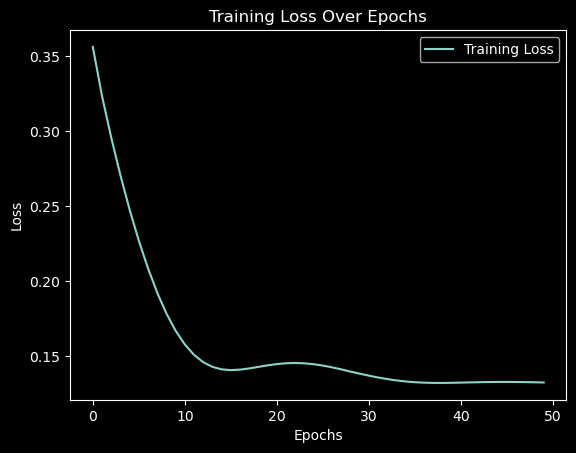

In [8]:
# Add self-loops to the graph
g = dgl.add_self_loop(g)

# Train the model
# Define training loop
def train(g, model, features, labels, epochs=50):
       # Initialize a list to store training losses
    training_losses = []

    model.train()
    for epoch in range(epochs):
        # Forward pass
        logits = model(g, features)
        
        # Compute loss (only for training nodes if using a train mask)
        loss = loss_fn(logits, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        # Print loss for monitoring
        # Save the loss for each epoch
        training_losses.append(loss.item())
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

    # Plot the training loss
    import matplotlib.pyplot as plt

    plt.plot(training_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

# Train the model
train(g, model, node_features, labels)


Accuracy: 0.9630
AUC-ROC: 0.7664


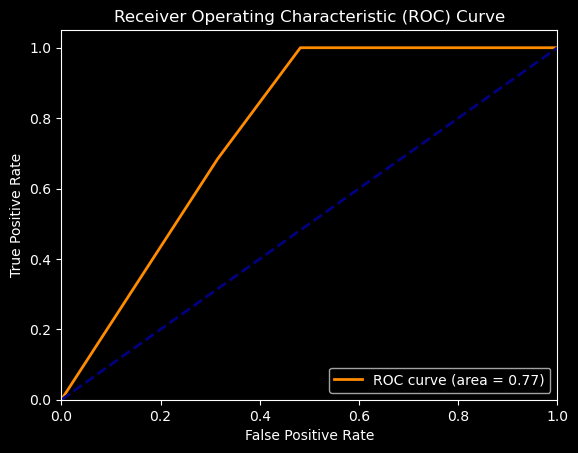

In [9]:
# Evaluate the model
# Define training loop
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve

# Switch to evaluation mode
model.eval()
with torch.no_grad():
    logits = model(g, node_features)
    probs = F.softmax(logits, dim=1)[:, 1].numpy()  # Probability for sepsis (class 1)
    preds = (probs > 0.5).astype(int)  # Threshold for binary classification

    # Calculate accuracy and AUC-ROC
    accuracy = accuracy_score(labels.numpy(), preds)
    auc_roc = roc_auc_score(labels.numpy(), probs)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, _ = roc_curve(labels.numpy(), probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

